PROBLEM 1: tSNE dim reduction

part A) Run tSNE library/package on MNIST and 20NG datasets, to obtain a representation is 2-dim or 3-dim, and visualize the data by plotting datapoints with a color per label. Try different values for perplexity like 5, 20 and 100.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

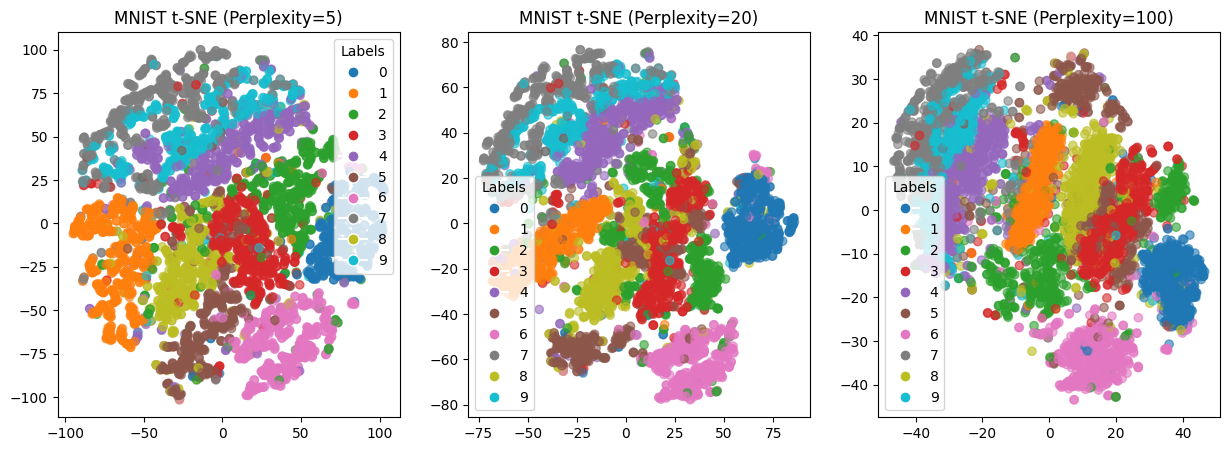

In [ ]:
# Load and preprocess MNIST
mnist = fetch_openml('mnist_784', version=1)
X_mnist, y_mnist = mnist.data[:5000], mnist.target[:5000].astype(int)  # sampling = 5000 images
X_mnist = StandardScaler().fit_transform(X_mnist)  # Normalizing

# t-SNE and plots for MNIST
perplexities = [5, 20, 100] #to csee how the model captures local and global structures
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(X_mnist)

    scatter = axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_mnist, cmap='tab10', alpha=0.6)
    axes[i].set_title(f'MNIST t-SNE (Perplexity={perplexity})')

    # Create legend
    unique_labels = np.unique(y_mnist)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) for label in unique_labels]
    axes[i].legend(handles, unique_labels, title="Labels", loc="best")

plt.show()

In [ ]:
#20NG
# Retrieve the dataset
from sklearn.datasets import fetch_20newsgroups
categories = ["alt.atheism", "sci.med", "sci.electronics", "comp.graphics", "talk.politics.guns", "sci.crypt"]
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

from sklearn.feature_extraction.text import TfidfVectorizer
#retrieving the data in the right format for the analysis

x = data.data  # Text: just separation of the data information using the dot
y = data.target  # labels: just retrievinig the labels information using the dot

# vectorizing the data (converting words into numerical features)
vectorizer = TfidfVectorizer(stop_words='english', max_features = 30000)
x_tfid= vectorizer.fit_transform(x).toarray()
print(f"x_tfid shape: {x_tfid.shape}")


# Fn to remove documents with zero std (meaning no variability in the information)
def remove_zero_std_doc(x,y):
  #calculate the std across each instance/document
  std_dev = np.std(x, axis=1) #considering all the roxws (axis =1) compute the std in x

  #identify rows/documents with std equal to zero
  non_zero_std_indices = np.where(std_dev != 0)[0]

  #filter documents with std = 0
  x_filtered = x[non_zero_std_indices]
  y_filtered = y[non_zero_std_indices]

  return x_filtered, y_filtered

#Applying the filtered functions to the data
x_filtered, y_filtered = remove_zero_std_doc(x_tfid, y)


print(x_filtered.shape)
print(y_filtered.shape)

x_tfid shape: (5647, 30000)
(5489, 30000)
(5489,)


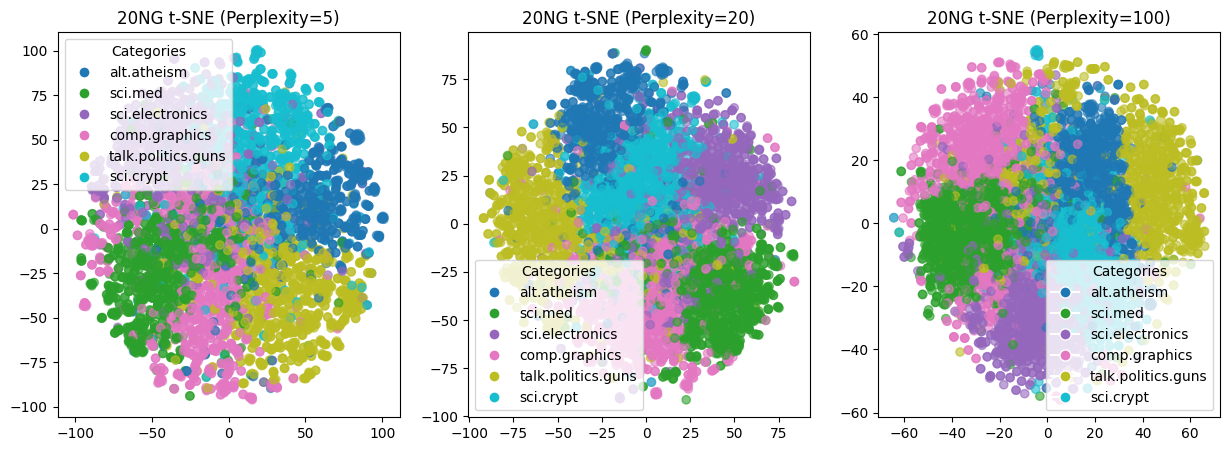

In [ ]:
# t-SNE and plots for 20 Newsgroups
perplexities = [5, 20, 100]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(x_filtered)

    scatter = axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_filtered, cmap='tab10', alpha=0.6)
    axes[i].set_title(f'20NG t-SNE (Perplexity={perplexity})')

    # Create legend
    unique_labels = np.unique(y_filtered)
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=8) for label in unique_labels]
    axes[i].legend(handles, categories, title="Categories", loc="best")

plt.show()

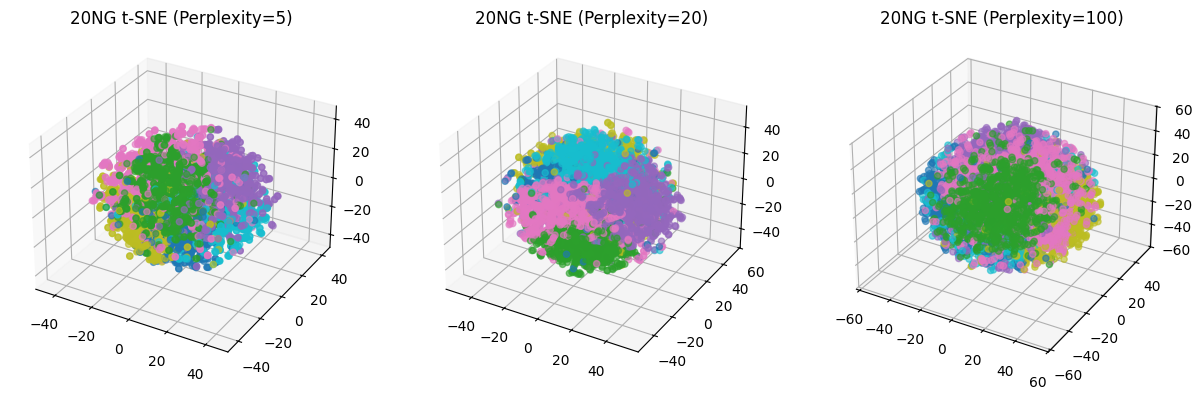

In [ ]:
# t-SNE visualization in 3D
perplexities = [5, 20, 100]
fig = plt.figure(figsize=(15, 5))

for i, perplexity in enumerate(perplexities):
    tsne = TSNE(n_components=3, perplexity=perplexity, random_state=42)
    X_tsne = tsne.fit_transform(x_filtered)

    ax = fig.add_subplot(1, 3, i+1, projection='3d')  # create 3D subplot
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=y_filtered, cmap='tab10', alpha=0.6)
    ax.set_title(f'20NG t-SNE (Perplexity={perplexity})')

plt.show()

part B) Run DBscan on tSNE-MNIST of G=2,3,5,10 dimensions. This should work much better than DBscan on original MNIST or on PCA-MNIST. You should be able to observe most datapoints "colored" and the colors roughly corresponding to image labels.

In [ ]:
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Load and preprocess MNIST
mnist = fetch_openml('mnist_784', version=1)
X_mnist, y_mnist = mnist.data[:5000], mnist.target[:5000].astype(int)
X_mnist = StandardScaler().fit_transform(X_mnist)

In [ ]:
# Reduce dimensionality with PCA (30D for faster t-SNE)
pca = PCA(n_components=30, random_state=42)
X_mnist_pca = pca.fit_transform(X_mnist)

In [ ]:
# Apply t-SNE for different G values
G_values = [2, 3, 5, 10] # outputs dimensions
X_tsne_dict = {}

for G in G_values:
    method = "barnes_hut" if G <= 3 else "exact" #barnes_hit does not work well with G > 3
    tsne = TSNE(n_components=G, perplexity=10, learning_rate=200, n_iter=500, random_state=42, method=method)
    X_tsne_dict[G] = tsne.fit_transform(X_mnist_pca)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [ ]:
# Apply DBSCAN and evaluate clustering
eps = 3
min_samples = 5
cluster_results = {}

for G in G_values:
    X_tsne = X_tsne_dict[G]
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    labels = dbscan.fit_predict(X_tsne)

    # Compute evaluation metrics
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_ratio = np.sum(labels == -1) / len(labels)
    silhouette = silhouette_score(X_tsne, labels) if n_clusters > 1 else -1
    db_index = davies_bouldin_score(X_tsne, labels) if n_clusters > 1 else -1

    cluster_results[G] = labels

    print(f"G={G}:")
    print(f"  - Number of clusters: {n_clusters}")  # Number of clusters detected (excluding noise)
    print(f"  - Noise ratio: {noise_ratio:.2f}")  # Percentage of points labeled as noise; lower is better
    print(f"  - Silhouette Score: {silhouette:.2f}")  # Measures how well-separated the clusters are (closer to 1 is better)
    print(f"  - Davies-Bouldin Index: {db_index:.2f}")  # Evaluates cluster compactness and separation (lower is better)
    print("-" * 40)

G=2:
  - Number of clusters: 9
  - Noise ratio: 0.00
  - Silhouette Score: -0.12
  - Davies-Bouldin Index: 1.18
----------------------------------------
G=3:
  - Number of clusters: 7
  - Noise ratio: 0.00
  - Silhouette Score: -0.47
  - Davies-Bouldin Index: 2.97
----------------------------------------
G=5:
  - Number of clusters: 2
  - Noise ratio: 0.00
  - Silhouette Score: -0.24
  - Davies-Bouldin Index: 3.44
----------------------------------------
G=10:
  - Number of clusters: 1
  - Noise ratio: 0.00
  - Silhouette Score: -1.00
  - Davies-Bouldin Index: -1.00
----------------------------------------


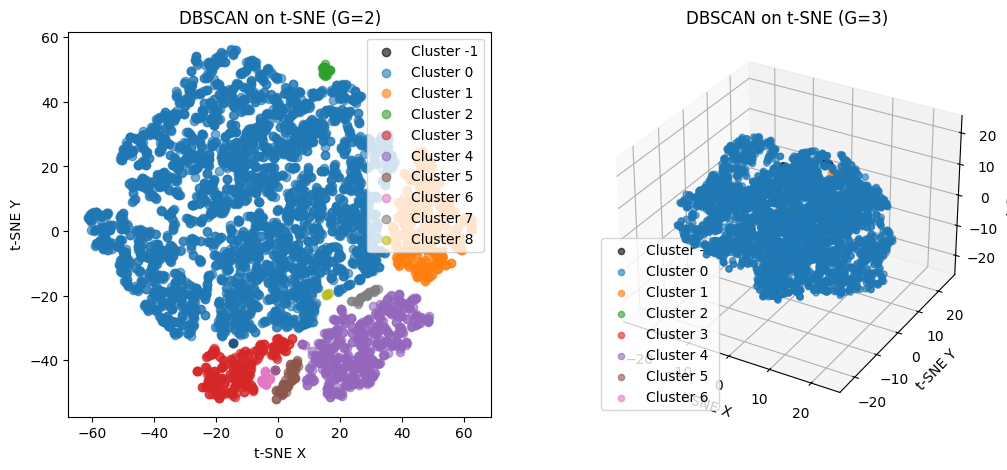

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

# Create figure for visualization
fig = plt.figure(figsize=(12, 5))

for i, G in enumerate([2, 3]):
    X_tsne = X_tsne_dict[G]  # Get t-SNE transformed data
    labels = cluster_results[G]  # Get DBSCAN cluster labels
    unique_labels = np.unique(labels)  # Get unique cluster IDs

    # Define colors for clusters
    cmap = plt.get_cmap('tab10')  # Use categorical colormap
    colors = [cmap(l % 10) for l in unique_labels if l != -1]  # Assign colors to clusters
    noise_color = 'black'  # Define color for noise (-1 label)

    if G == 2:
        # 2D plot for G=2
        ax = fig.add_subplot(1, 2, i + 1)
        for label in unique_labels:
            mask = labels == label  # Get points belonging to the cluster
            color = noise_color if label == -1 else colors[label % 10]  # Assign color
            ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], c=[color], label=f'Cluster {label}', alpha=0.6)

        ax.set_xlabel("t-SNE X")
        ax.set_ylabel("t-SNE Y")
        ax.set_title(f'DBSCAN on t-SNE (G={G})')
        ax.legend()

    else:
        # 3D plot for G=3
        ax = fig.add_subplot(1, 2, i + 1, projection='3d')
        for label in unique_labels:
            mask = labels == label
            color = noise_color if label == -1 else colors[label % 10]
            ax.scatter(X_tsne[mask, 0], X_tsne[mask, 1], X_tsne[mask, 2], c=[color], label=f'Cluster {label}', alpha=0.6)

        ax.set_xlabel("t-SNE X")
        ax.set_ylabel("t-SNE Y")
        ax.set_zlabel("t-SNE Z")
        ax.set_title(f'DBSCAN on t-SNE (G={G})')
        ax.legend()

plt.show()




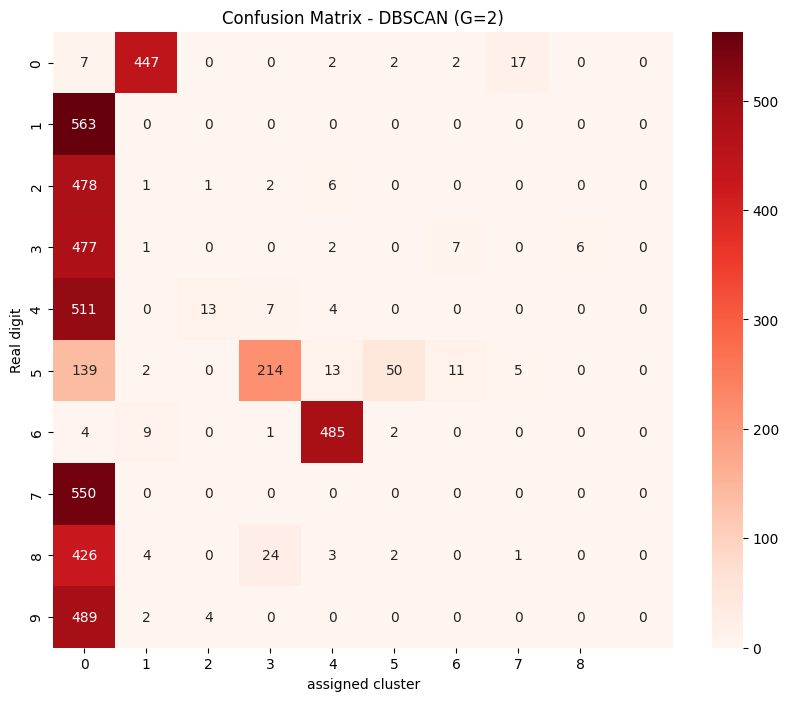

In [ ]:
# Compute and plot confusion matrix for the best G (choose the one with highest silhouette score)
from sklearn.metrics import confusion_matrix
import seaborn as sns


G_selected = 2
X_tsne = X_tsne_dict[G_selected]
labels = cluster_results[G_selected]

# Filtering noise (-1)
valid_idx = labels != -1
filtered_labels = labels[valid_idx]
filtered_y_mnist = y_mnist[valid_idx]

#CM
cm = confusion_matrix(filtered_y_mnist, filtered_labels)

# plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=np.unique(filtered_labels), yticklabels=np.arange(10))
plt.xlabel("assigned cluster")
plt.ylabel("Real digit")
plt.title(f"Confusion Matrix - DBSCAN (G={G_selected})")
plt.show()


G=2 performs best, but still has a low silhouette score.

G=3 and higher lead to poor clustering, likely due to distortions in t-SNE.
Higher dimensions (G=5, G=10) merge clusters, making DBSCAN ineffective.

For clustering, G=2 is the best choice, but even then, the results are suboptimal since sampling issues (considering 5000 samples may not be representative)